## If it can converge to the optimal solution when learning rate is 0.1:

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 100
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = [1e-1, 1e-2, 1e-3]
LR = 1e-2
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [7]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
###############################################################

def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [8]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [9]:
optimizer1 = optim.SGD(model.parameters(), lr=LEARNING_RATE[0], momentum=MOMENTUM)

scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=STEP, gamma=GAMMA)

In [10]:
training_loss1 = []
training_acc1 = []
testing_loss1 = []
testing_acc1 = []

start_time1 = time.time()


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss1.append(epoch_loss)
    training_acc1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler1.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss1.append(val_loss)
        testing_acc1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch + 1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))


end_time1 = time.time()

execution_time1 = end_time1 - start_time1

print(f"代码块执行时间为: {execution_time1} 秒")

Epoch: 1/100 Train Loss: 0.0154 Acc: 0.2525
Begin test......
Test Loss: 0.0139 Acc: 0.3435
Epoch: 2/100 Train Loss: 0.0144 Acc: 0.3123
Begin test......
Test Loss: 0.0141 Acc: 0.3261
Epoch: 3/100 Train Loss: 0.0141 Acc: 0.3276
Begin test......
Test Loss: 0.0133 Acc: 0.3882
Epoch: 4/100 Train Loss: 0.0138 Acc: 0.3449
Begin test......
Test Loss: 0.0131 Acc: 0.3694
Epoch: 5/100 Train Loss: 0.0137 Acc: 0.3536
Begin test......
Test Loss: 0.0133 Acc: 0.3727
Epoch: 6/100 Train Loss: 0.0129 Acc: 0.3939
Begin test......
Test Loss: 0.0121 Acc: 0.4376
Epoch: 7/100 Train Loss: 0.0126 Acc: 0.4101
Begin test......
Test Loss: 0.0122 Acc: 0.4211
Epoch: 8/100 Train Loss: 0.0126 Acc: 0.4129
Begin test......
Test Loss: 0.0123 Acc: 0.4272
Epoch: 9/100 Train Loss: 0.0125 Acc: 0.4135
Begin test......
Test Loss: 0.0116 Acc: 0.4577
Epoch: 10/100 Train Loss: 0.0124 Acc: 0.4243
Begin test......
Test Loss: 0.0118 Acc: 0.4688
Epoch: 11/100 Train Loss: 0.0119 Acc: 0.4487
Begin test......
Test Loss: 0.0112 Acc: 0.48

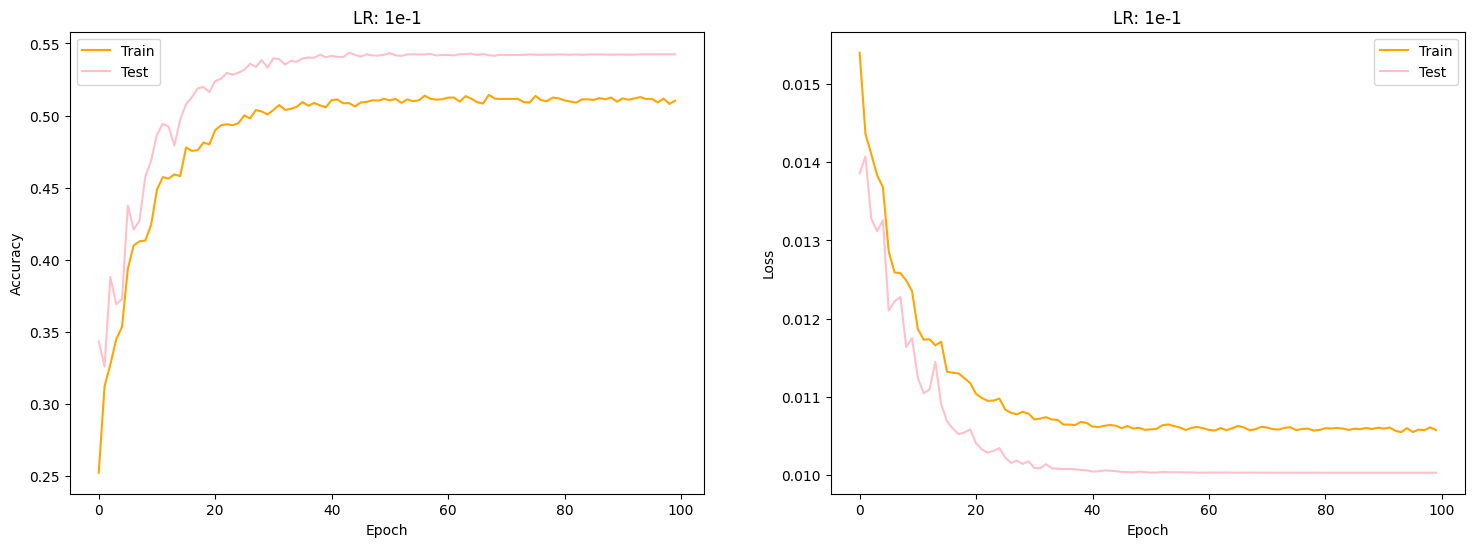

In [13]:
import matplotlib.pyplot as plt
x = np.arange(NUM_EPOCHS)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 绘制 LR=1e-1 的曲线
axs[0].set_title("LR: 1e-1")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].plot(x, training_acc1, label="Train", color="orange", linestyle="-")
axs[0].plot(x, testing_acc1, label="Test", color="pink", linestyle="-")
axs[0].legend()

# 绘制 LR=1e-1 的损失曲线
axs[1].set_title("LR: 1e-1")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].plot(x, training_loss1, label="Train", color="orange", linestyle="-")
axs[1].plot(x, testing_loss1, label="Test", color="pink", linestyle="-")
axs[1].legend()

In [15]:
subset1 = testing_acc1[39:99]
subset2 = training_acc1[39:99]

# 计算平均值
average1 = sum(subset1) / len(subset1)
average2 = sum(subset2) / len(subset2)

print("epoch 40-100的testing accuracy平均值为:", average1)
print("epoch 40-100的training accuracy平均值为:", average2)

epoch 40-100的testing accuracy平均值为: 0.5421600000000005
epoch 40-100的training accuracy平均值为: 0.5108196666666668
